In [52]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from behavenet.fitting.utils import build_data_generator, create_tt_experiment
from behavenet.fitting.utils import add_lab_defaults_to_parser, get_output_session_dir, get_expt_dir
from test_tube import HyperOptArgumentParser
from behavenet.fitting.decoding_grid_search import get_decoding_params

In [53]:
def get_params(strategy, args):

    parser = HyperOptArgumentParser(strategy)

    # most important arguments
    parser.add_argument('--search_type', type=str)  # grid_search, test
    parser.add_argument('--lab_example', type=str)  # musall, steinmetz, datta
    parser.add_argument('--tt_save_path', type=str)
    parser.add_argument('--data_dir', type=str)
    parser.add_argument('--model_type', default='ff', choices=['ff', 'ff-mv', 'linear', 'linear-mv', 'lstm'], type=str)
    parser.add_argument('--model_class', default='neural-ae', choices=['neural-ae', 'neural-arhmm', 'ae-neural', 'arhmm-neural'], type=str)
    parser.add_argument('--sessions_csv', default='', type=str, help='specify multiple sessions')

    # arguments for computing resources (infer n_gpu_workers from visible gpus)
    parser.add_argument('--tt_n_gpu_trials', default=1000, type=int)
    parser.add_argument('--tt_n_cpu_trials', default=100000, type=int)
    parser.add_argument('--tt_n_cpu_workers', default=5, type=int)
    parser.add_argument('--mem_limit_gb', default=8.0, type=float)
    parser.add_argument('--gpus_viz', default='0;1', type=str)

    # add data generator arguments
    parser.add_argument('--reg_list', default='none', type=str, choices=['none', 'arg', 'all'])
    parser.add_argument('--subsample_regions', default='none', choices=['none', 'single', 'loo'])
    parser.add_argument('--device', default='cuda', type=str)
    parser.add_argument('--as_numpy', action='store_true', default=False)
    parser.add_argument('--batch_load', action='store_true', default=False)
    parser.add_argument('--rng_seed', default=0, type=int)

    # add fitting arguments
    parser.add_argument('--val_check_interval', default=1)

    # get lab-specific arguments
    namespace, extra = parser.parse_known_args(args)
    add_lab_defaults_to_parser(parser, namespace.lab_example)
    namespace, extra = parser.parse_known_args(args)  # ugly

    # add regions to opt_list if desired
    if namespace.reg_list == 'all':
        parser.opt_list('--region', options=get_region_list(namespace), type=str, tunable=True)
    elif namespace.reg_list == 'arg':
        parser.add_argument('--region', default='all', type=str)
    elif namespace.reg_list == 'none':  # TODO: fix this ambiguity
        parser.add_argument('--region', default='all', type=str)
    else:
        raise ValueError(
            '"%s" is not a valid region_list' % namespace.region_list)

    get_decoding_params(namespace, parser)

    return parser.parse_args(args)

In [54]:
command_line_arg = '--search_type test --lab_example musall --animal mSM36 --session 05-Dec-2017 --tt_save_path /media/gssda/behavenet/results/ --data_dir /media/gssda/behavenet/data/  --model_type ff --model_class neural-ae --experiment_name grid_search --export_predictions --ae_experiment_name ae-dim-test --ae_model_type conv --n_ae_latents 8 --min_n_epochs 10 --max_n_epochs 500 --device cpu --n_lags 4 --l2_reg 1e-4 --n_hid_layers 3 --ae_multisession 0'
hparams = get_params('grid_search', command_line_arg.split(' '))
hparams = vars(hparams)
hparams.pop('trials', False)
hparams.pop('generate_trials', False)
hparams.pop('optimize_parallel', False)
hparams.pop('optimize_parallel_cpu', False)
hparams.pop('optimize_parallel_gpu', False)
hparams.pop('optimize_trials_parallel_gpu', False)

# create test-tube experiment
#hparams, sess_ids, exp = create_tt_experiment(hparams)
hparams['session_dir'], sess_ids = get_output_session_dir(hparams)
hparams['expt_dir'] = 'temp/'
hparams['version'] = 0
# build data generator
ae_data_generator = build_data_generator(hparams, sess_ids)


using data from following sessions:
/media/gssda/behavenet/results/musall/vistrained/mSM36/05-Dec-2017
constructing data generator...done
Generator contains 1 SingleSessionDataset objects:
	signals: ['neural', 'ae_latents']
	transforms: [Compose(ZScore()), None]
	paths: ['/media/gssda/behavenet/data/musall/vistrained/mSM36/05-Dec-2017/data.hdf5', '/media/gssda/behavenet/results/musall/vistrained/mSM36/multisession-00/ae/conv/08_latents/ae-dim-test/version_1/latents.pkl']




In [55]:
command_line_arg = '--search_type test --lab_example musall --animal mSM36 --session 05-Dec-2017 --tt_save_path /media/gssda/behavenet/results/ --data_dir /media/gssda/behavenet/data/ --model_type ff --model_class neural-arhmm --experiment_name grid_search --n_ae_latents 8 --arhmm_experiment_name grid_search --n_arhmm_states 16 --kappa 0 --noise_type gaussian --min_n_epochs 10 --max_n_epochs 500 --n_lags 4 --l2_reg 1e-4 --n_hid_layers 1 --arhmm_multisession 0 --device cpu'
hparams = get_params('grid_search', command_line_arg.split(' '))
hparams = vars(hparams)
hparams.pop('trials', False)
hparams.pop('generate_trials', False)
hparams.pop('optimize_parallel', False)
hparams.pop('optimize_parallel_cpu', False)
hparams.pop('optimize_parallel_gpu', False)
hparams.pop('optimize_trials_parallel_gpu', False)

# create test-tube experiment
#hparams, sess_ids, exp = create_tt_experiment(hparams)
hparams['session_dir'], sess_ids = get_output_session_dir(hparams)
hparams['expt_dir'] = 'temp/'
hparams['version'] = 0
# build data generator
arhmm_data_generator = build_data_generator(hparams, sess_ids)


using data from following sessions:
/media/gssda/behavenet/results/musall/vistrained/mSM36/05-Dec-2017
constructing data generator...done
Generator contains 1 SingleSessionDataset objects:
	signals: ['neural', 'arhmm']
	transforms: [Compose(ZScore()), None]
	paths: ['/media/gssda/behavenet/data/musall/vistrained/mSM36/05-Dec-2017/data.hdf5', '/media/gssda/behavenet/results/musall/vistrained/mSM36/multisession-00/arhmm/08_latents/16_states/0e+00_kappa/gaussian/grid_search/version_2/states.pkl']




In [56]:
N=545

ae_neural = [None for i in range(N)]
ae_latents = [None for i in range(N)]
arhmm_neural = [None for i in range(N)]
arhmm_states = [None for i in range(N)]

for ii in range(ae_data_generator.n_tot_batches['train']):
    ae_data, _ = ae_data_generator.next_batch('train')
    arhmm_data, _ = arhmm_data_generator.next_batch('train')
    
    ae_neural[ae_data['batch_indx'].item()] = ae_data['neural'].cpu().detach().numpy().squeeze()
    ae_latents[ae_data['batch_indx'].item()] = ae_data['ae_latents'].cpu().detach().numpy().squeeze()
    
    arhmm_neural[arhmm_data['batch_indx'].item()] = arhmm_data['neural'].cpu().detach().numpy().squeeze()
    arhmm_states[arhmm_data['batch_indx'].item()] = arhmm_data['arhmm'].cpu().detach().numpy().squeeze()
    
ae_neural = [v for v in ae_neural if v is not None]
ae_latents = [v for v in ae_latents if v is not None]
arhmm_neural = [v for v in arhmm_neural if v is not None]
arhmm_states = [v for v in arhmm_states if v is not None]
             

In [59]:
np.savez('arhmm_decoding_data.npz',neural=ae_neural, latents=ae_latents, states':arhmm_states})

In [11]:
# Have to lag the neural activity for each batch

from sklearn.linear_model import LogisticRegression, LinearRegression

W = 8
N = ae_neural[0].shape[1]
nlags=3 # for AR
D = ae_latents[0].shape[1]
neural_window = [_ for i in range(len(ae_neural))]
for i in range(len(ae_neural)):
    T = ae_neural[i].shape[0]
    neural_pad = np.concatenate([np.zeros((W//2, N)), ae_neural[i], np.zeros((W//2, N))])
    neural_window[i] = np.column_stack([neural_pad[w:T+w] for w in range(W)] )


In [12]:
T=3000
training_neural =np.concatenate(neural_window,axis=0)[:T]
training_arhmm = np.concatenate(arhmm_states,axis=0)[:T]
training_ae = np.concatenate(ae_latents,axis=0)[:T]

In [13]:
# Logistic/linear regressions
from sklearn.linear_model import LogisticRegression, LinearRegression

recog_z = LogisticRegression(solver='lbfgs', max_iter=500)
recog_z.fit(training_neural, training_arhmm)
#log_qz = recog_z.predict_log_proba(ns_window)



/home/erb2180/miniconda3/envs/behavenet/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
W = nlags
xs_pad = np.concatenate([np.zeros((W-1,D)), training_ae])
xs_eff = np.column_stack([xs_pad[w:T+w] for w in reversed(range(W))])

recog_x = LinearRegression()
recog_x.fit(training_neural, xs_eff)
# q_mu_x = recog_x.predict(training_neural)
# q_Sigma_x = np.cov((training_ae - q_mu_x).T)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
# Load in ARHMM model and get transition matrix

import pickle
arhmm_model = pickle.load(open('/media/gssda/behavenet/results/musall/vistrained/mSM36/multisession-00/arhmm/08_latents/16_states/0e+00_kappa/gaussian/grid_search/version_2/best_val_model.pt','rb'))
P = arhmm_model.transitions.transition_matrix

As = arhmm_model.observations.As
bs = arhmm_model.observations.bs
Qs = arhmm_model.observations.Sigmas

evals, evecs = np.linalg.eig(P.T)
perm = np.argsort(evals)[::-1]
evals, evecs = evals[perm], evecs[:, perm]
assert np.allclose(evals[0], 1.0)
if np.any(evecs[:,0] <= 0):
    evecs[:,0] = -1*evecs[:,0]
assert np.all(evecs[:,0] >= 0) 
pz_infty = np.real(evecs[:, 0] / evecs[:, 0].sum())

K = P.shape[0]
D = training_ae.shape[1]

mu_infty = np.zeros((K, D*nlags))
Sigma_infty = np.zeros((K, D*nlags, D*nlags))
for k in range(K):
    mu_infty[k] = np.mean(xs_eff[training_arhmm == k])
    #Sigma_infty[k] = np.cov(training_ae[training_arhmm == k].T)
    Sigma_infty[k] = np.cov(xs_eff.T)
    
mu0 = np.zeros(D)
Sigma0 = np.eye(D)

In [31]:
# Make effective AR matrices

# Make the big A matrix
As_eff = np.zeros((K, D * nlags, D * nlags))
for k in range(K):
    for l in range(nlags):
        As_eff[k, :D, D*l:D*(l+1)] = As[k, :, l*D:(l+1)*D]
        if l < nlags - 1:
            As_eff[k, (l+1)*D:(l+2)*D, l*D:(l+1)*D] = np.eye(D)

# plt.imshow(big_As[0])
# plt.colorbar()

# Make the big Q (covariance) matrix
Qs_eff = np.zeros((K, D * nlags, D * nlags))
for k in range(K):
    Qs_eff[k, :D, :D] = Qs[k]
    for l in range(1, nlags):
        Qs_eff[k, l*D:(l+1)*D, l*D:(l+1)*D] = 1e-16 * np.eye(D)

bs_eff = np.zeros((K, D * nlags))
for k in range(K):
    bs_eff[k, :D] = bs[k]

# plt.imshow(big_Q[0])
# plt.colorbar()

mu0_eff = np.concatenate((mu0, mu0, mu0))
Sigma0_eff = np.zeros((D*nlags, D*nlags))
for l in range(nlags):
    Sigma0_eff[l*D:(l+1)*D, l*D:(l+1)*D] = Sigma0

In [32]:
np.min(np.linalg.eigvals(Sigma_infty))

0.0011808777269219275

In [51]:
np.min(np.linalg.eigvals(q_Sigma_x))

0.02201264067272425

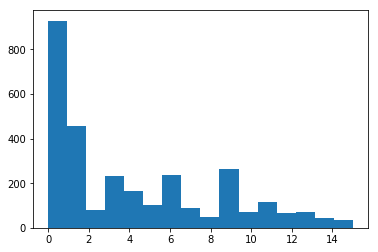

In [55]:
plt.hist(training_arhmm,bins=16);

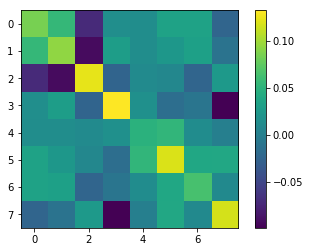

In [46]:
plt.imshow(Sigma_infty[15])
plt.colorbar()

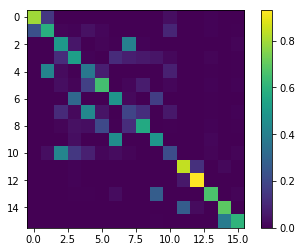

In [11]:
plt.imshow(P)
plt.colorbar()

In [33]:
# Use the information form.  It will generalize better to VI.
from pylds.lds_messages_interface import info_E_step

# Compute the info potentials for the initial condition
def _info_params(mu0, Sigma0, As, bs, Qs, q_mu_x, q_Sigma_x, Sigma_infty, mu_infty, Ez, z_sample):
    # parameter checking
    T, K = Ez.shape
    assert As.shape[0] == K and As.ndim == 3 and As.shape[1] == As.shape[2]
    D = As.shape[1]
    assert mu0.shape == (D,)
    assert Sigma0.shape == (D, D)
    assert bs.shape == (K, D)
    assert Qs.shape == (K, D, D)
    assert q_mu_x.shape == (T, D)
    assert q_Sigma_x.shape == (D, D)
    
    # Make pseudo-inputs (all ones) for bias terms
    inputs = np.ones((T, 1))
    
    # Convert initial distribution to info form
    # (ignore normalizing constants)
    J0 = np.linalg.inv(Sigma0)
    h0 = J0 @ mu0
    log_Z0 = 0

    # Info dynamics parameters
    J_pair_22 = np.linalg.inv(Qs)
    J_pair_21 = -np.matmul(np.linalg.inv(Qs), As)
    J_pair_11 = np.matmul(np.swapaxes(As, 1, 2), -J_pair_21)
    mBTQiA = np.matmul(np.swapaxes(bs[:, :, None], 1, 2), J_pair_21)
    BTQi = np.matmul(np.swapaxes(bs[:, :, None], 1, 2), J_pair_22)

    # Get expected sufficient statistics by integrating over z
    J_pair_22 = np.einsum('tk, kij -> tij', Ez[:-1], J_pair_22)
    J_pair_21 = np.einsum('tk, kij -> tij', Ez[:-1], J_pair_21)
    J_pair_11 = np.einsum('tk, kij -> tij', Ez[:-1], J_pair_11)
    mBTQiA = np.einsum('tk, kij -> tij', Ez[:-1], mBTQiA)
    BTQi = np.einsum('tk, kij -> tij', Ez[:-1], BTQi)
    h_pair_1 = np.einsum('tu, tud -> td', inputs[:-1], mBTQiA)
    h_pair_2 = np.einsum('tu, tud -> td', inputs[:-1], BTQi)
    log_Z_pair = np.zeros(T-1)

    # Info emission parameters
    J_obs = (np.linalg.inv(q_Sigma_x)+100*np.eye(8*3) - np.linalg.inv(Sigma_infty))[z_sample]
    h_recog = np.linalg.solve(q_Sigma_x, q_mu_x.T).T
    h_infty = np.linalg.solve(Sigma_infty, mu_infty)[z_sample]
    h_obs = h_recog + h_infty
    log_Z_obs = np.zeros(T)
    
    return J0, h0, log_Z0, \
           J_pair_11, J_pair_21, J_pair_22, h_pair_1, h_pair_2, log_Z_pair, \
           J_obs, h_obs, log_Z_obs


In [51]:
# n_iter = 100
# t=50

# from ssm.stats import multivariate_normal_logpdf
# from ssm.primitives import hmm_expected_states, hmm_sample
# from pylds.lds_messages_interface import info_E_step


# # Initialize q(z) with just the learned recognition potential
# log_qz = recog_z.predict_log_proba(neural_window[t])
# q_mu_x = recog_x.predict(neural_window[t])

# xs_pad = np.concatenate([np.zeros((W-1,D)), ae_latents[t]])
# xs_eff = np.column_stack([xs_pad[w:ae_latents[t].shape[0]+w] for w in reversed(range(W))])

# q_Sigma_x = np.cov((xs_eff - q_mu_x).T)

# z_potential = log_qz - np.log(pz_infty)
# Ez, _, _ = hmm_expected_states(np.log(pz_infty), np.log(P)[None, :, :], z_potential)
# z_sample = hmm_sample(np.log(pz_infty), np.log(P)[None, :, :], z_potential)

for i in range(n_iter):
    # compute the expected value of x given z and the observation potential
    _, Ex, _, _ = info_E_step(
        *_info_params(mu0_eff, Sigma0_eff, As_eff, bs_eff, Qs_eff, 
                      q_mu_x, q_Sigma_x, Sigma_infty, mu_infty, Ez, z_sample)
    )
    
    # Update z, now including the dynamics potential
    # TODO: Should really include the covariance of x in this update too
    z_dyn_potential = np.column_stack(
        [multivariate_normal_logpdf(Ex[1:], Ex[:-1] @ A.T + b, Q) 
         for A, b, Q in zip(As_eff, bs_eff, Qs_eff)])
    z_dyn_potential = np.row_stack((np.zeros(K), z_dyn_potential))
    z_potential = log_qz - np.log(pz_infty) + z_dyn_potential
    Ez, _, _ = hmm_expected_states(np.log(pz_infty), np.log(P)[None, :, :], z_potential)

    print("MSE: ", np.mean((Ex[:,:D] - ae_latents[t])**2))

MSE:  42411430.32192369
MSE:  0.8918683104431435
MSE:  72787220.27350566
MSE:  0.8904151838114185
MSE:  2339641.6004939135
MSE:  0.892744092071649
MSE:  130989226.94931588
MSE:  0.8907807482271606
MSE:  42411430.32192369
MSE:  0.8918683104431435
MSE:  72787220.27350566
MSE:  0.8904151838114185
MSE:  2339641.6004939135
MSE:  0.892744092071649
MSE:  130989226.94931588
MSE:  0.8907807482271606
MSE:  42411430.32192369
MSE:  0.8918683104431435
MSE:  72787220.27350566
MSE:  0.8904151838114185
MSE:  2339641.6004939135
MSE:  0.892744092071649
MSE:  130989226.94931588
MSE:  0.8907807482271606
MSE:  42411430.32192369
MSE:  0.8918683104431435
MSE:  72787220.27350566
MSE:  0.8904151838114185
MSE:  2339641.6004939135
MSE:  0.892744092071649
MSE:  130989226.94931588
MSE:  0.8907807482271606
MSE:  42411430.32192369
MSE:  0.8918683104431435
MSE:  72787220.27350566
MSE:  0.8904151838114185
MSE:  2339641.6004939135
MSE:  0.892744092071649
MSE:  130989226.94931588
MSE:  0.8907807482271606
MSE:  42411430.

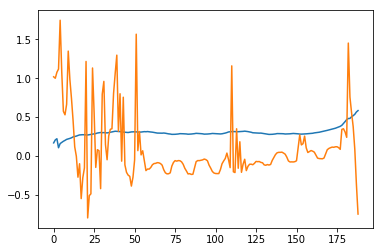

In [49]:
plt.plot(Ex[:,1])
plt.plot(ae_latents[t][:,1])